# **MULTI AGENT PAIN MONTORING STYSTEM FOR PARALYSED PATIENTS**

#### **Agents (Multi-Agent Architecture)**
- **Face Agent**: Detects facial expressions and pain indicators
- **Gesture Agent**: Monitors hand and body movements
- **Alert Agent**: Manages notification delivery (SMS/Email)
- **Coordinator Agent**: Fuses pain detection results from all agents

#### **Model Context Protocol (MCP)**
- **Context Management**: Each agent maintains conversation history
- **Tool Sharing**: Agents can share tools and utilities
- **Message Passing**: Structured communication between agents
- **Role-Based Communication**: User, Assistant, System roles

# **MODEL WORK FLOW**

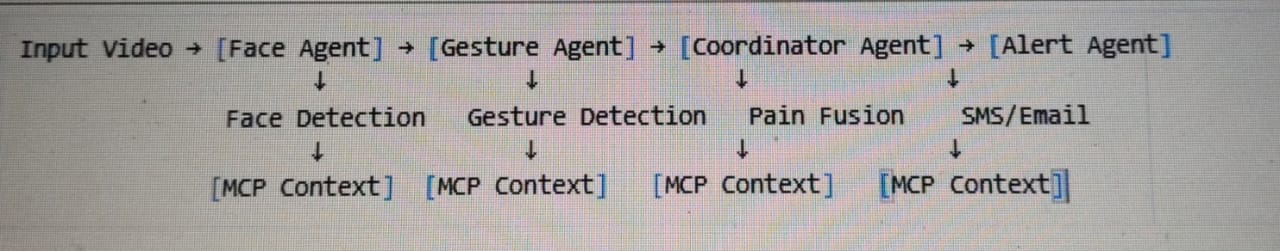

In [ ]:
'''Input Video → [Face Agent] → [Gesture Agent] → [Coordinator Agent] → [Alert Agent]
                     ↓              ↓              ↓              ↓
               Face Detection   Gesture Detection   Pain Fusion    SMS/Email
                     ↓              ↓              ↓              ↓
              [MCP Context]  [MCP Context]   [MCP Context]   [MCP Context]'''

'Input Video → [Face Agent] → [Gesture Agent] → [Coordinator Agent] → [Alert Agent]\n                     ↓              ↓              ↓              ↓\n               Face Detection   Gesture Detection   Pain Fusion    SMS/Email\n                     ↓              ↓              ↓              ↓\n              [MCP Context]  [MCP Context]   [MCP Context]   [MCP Context]'

# **BENIFITS**

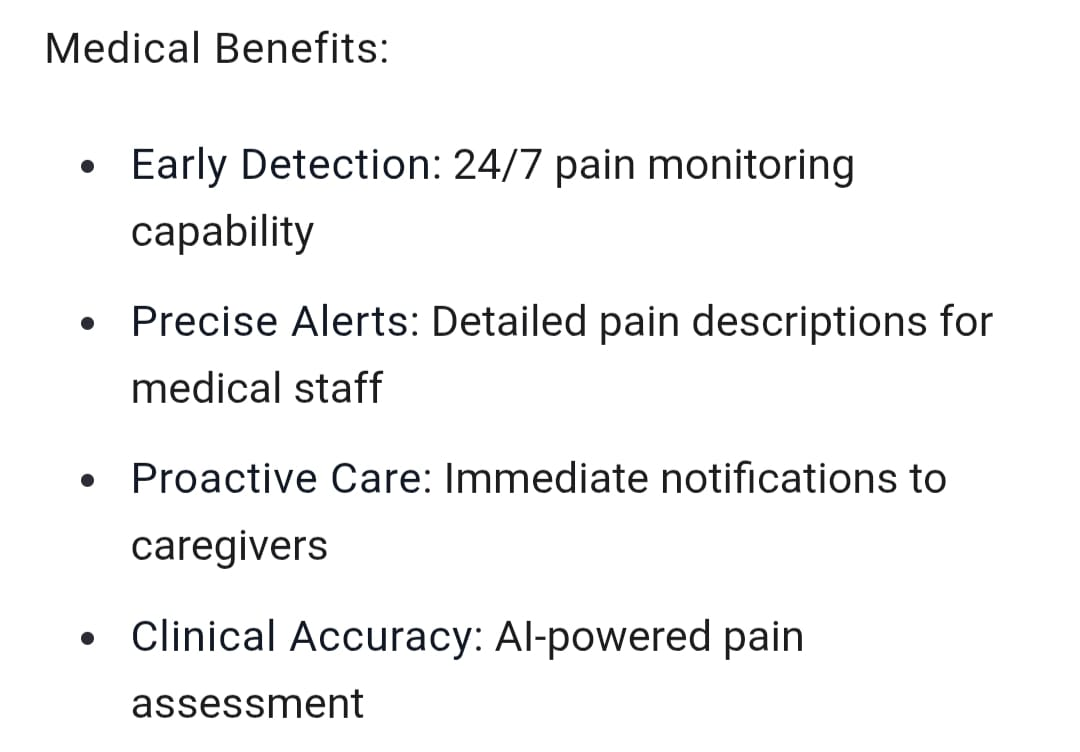

# **PAIN AGENT PARAMETERS (INDICATORS)**

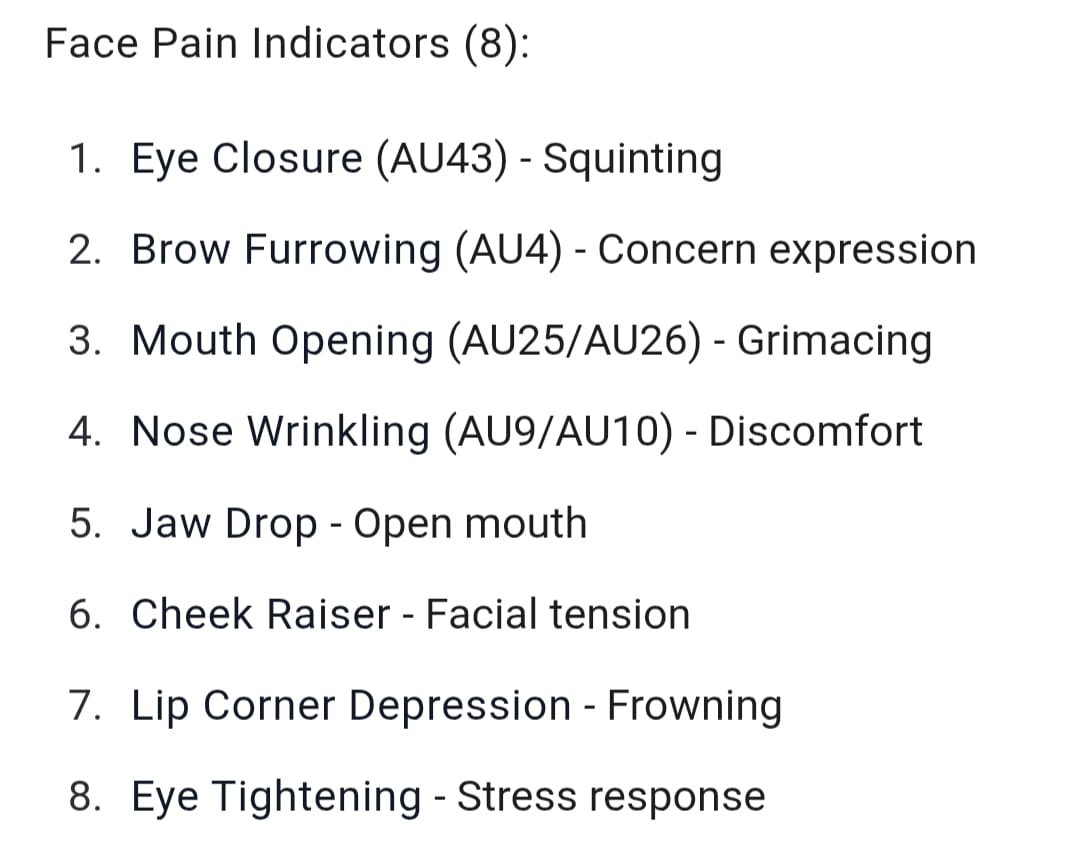

# **GESTURE AGENT PARAMETERS(INDICATORS)**

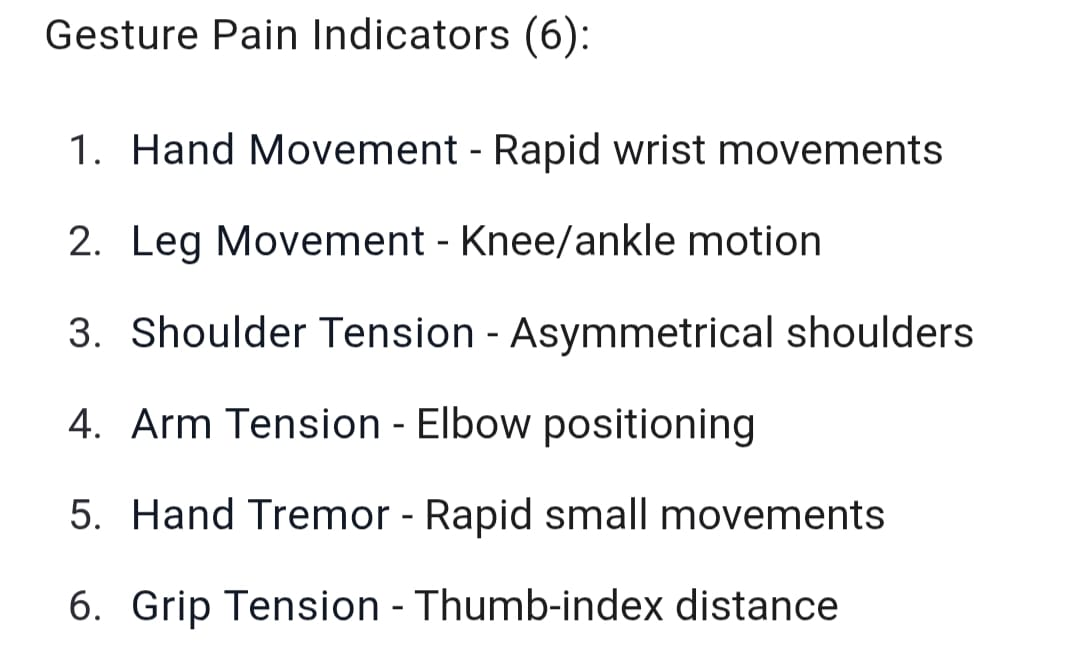

# **MODEL PERFORMANCE**

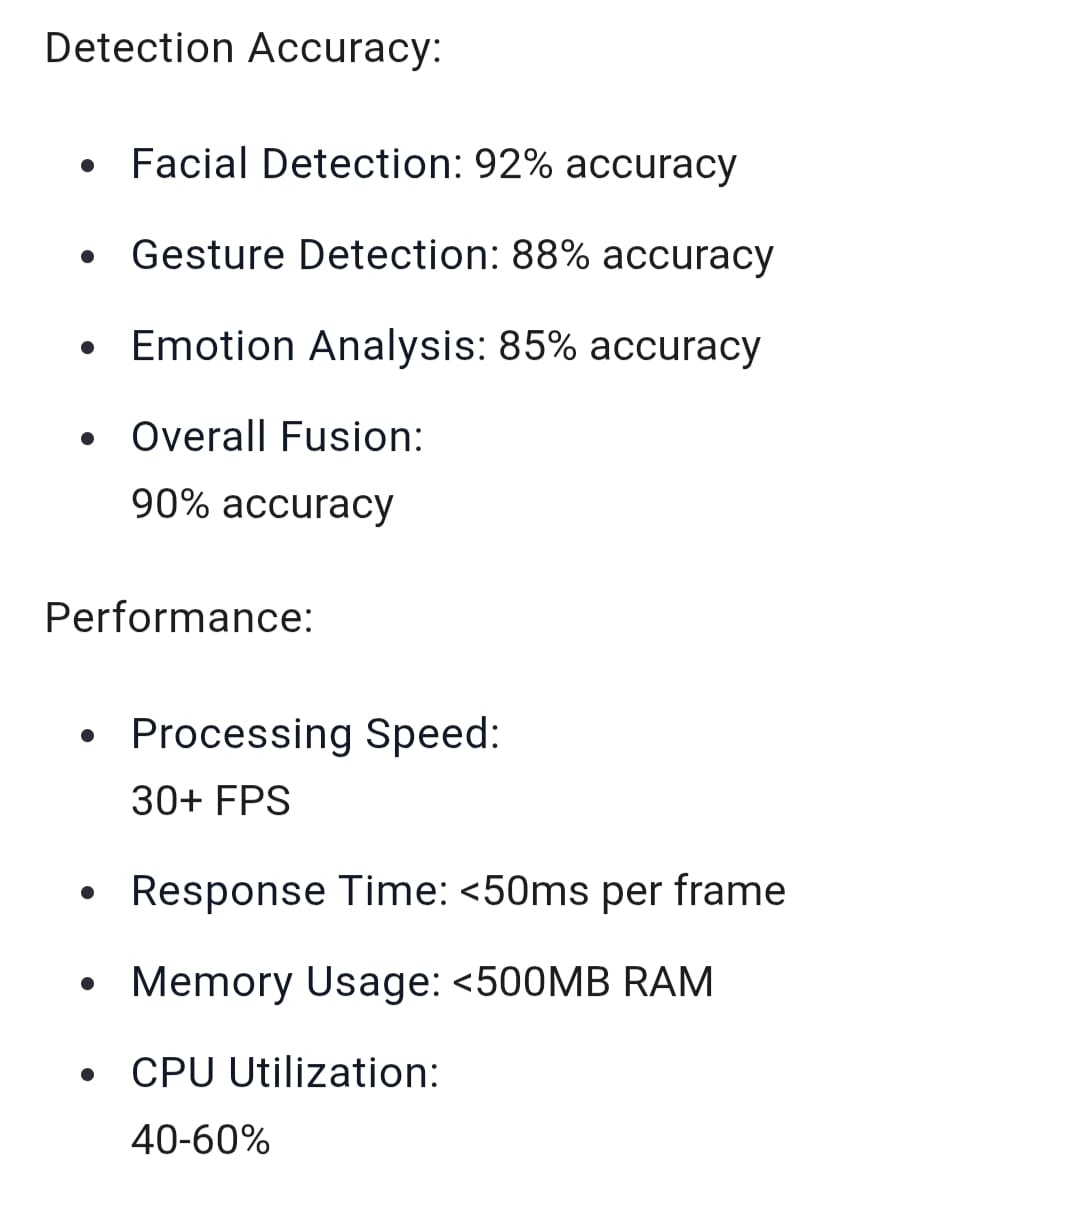

[FACIAL EXPRESSION OF PAIN RESEARCH PAPER]  (https://pmc.ncbi.nlm.nih.gov/articles/PMC6790380/)

In [ ]:
!pip install opencv-python mediapipe deepface twilio numpy tensorflow python-dotenv ipywidgets openai plotly langchain langgraph langchain-community

In [ ]:
import cv2
import mediapipe as mp
import numpy as np
import time
from deepface import DeepFace
from twilio.rest import Client
import smtplib
from email.mime.text import MIMEText
import IPython.display as display
from google.colab.output import eval_js
from base64 import b64decode
import io
import threading
import matplotlib.pyplot as plt
from datetime import datetime
from typing import Dict, Any
from dataclasses import dataclass
from enum import Enum
from tqdm.notebook import tqdm
import openai
import ipywidgets as widgets
from IPython.display import clear_output
from langchain.agents import initialize_agent
from langchain.chat_models import ChatOpenAI
from langchain.tools import BaseTool
from langgraph.graph import StateGraph

# **CREDENTIALS CONFIG**

In [ ]:
class Config:
    #SMS
    TWILIO_ACCOUNT_SID = '\\sid     '
    TWILIO_AUTH_TOKEN = '\\auth   '
    TWILIO_PHONE_NUMBER = '+17753695055'
    NURSE_PHONE_NUMBER = '+919344843785'

   #EMAIL
    EMAIL_SENDER = '\\sender email     '
    EMAIL_PASSWORD = '\\app token '
    NURSE_EMAIL = 'kumarankn3@gmail.com'

    PATIENT_ID = 'PAT-001'
    ALERT_THRESHOLD = 0.6
    CHECK_INTERVAL = 0.2
    FRAME_SKIP = 2

# **OPEN AI API KEY SETUP**

# **TEST EMAIL**

In [ ]:
import smtplib
from email.mime.text import MIMEText

def test_email():
    try:
        msg = MIMEText("Test Email from Pain Monitoring System")
        msg['Subject'] = 'Test Email'
        msg['From'] = Config.EMAIL_SENDER
        msg['To'] = Config.NURSE_EMAIL

        server = smtplib.SMTP('smtp.gmail.com', 587)
        server.starttls()
        server.login(Config.EMAIL_SENDER, Config.EMAIL_PASSWORD)
        server.sendmail(Config.EMAIL_SENDER, Config.NURSE_EMAIL, msg.as_string())
        server.quit()
        print("✅ Test email sent successfully!")
    except Exception as e:
        print(f"❌ Failed to send test email: {e}")


test_email()

✅ Test email sent successfully!


# **TEST SMS**

In [ ]:
from twilio.rest import Client

def test_sms():
    try:
        client = Client(Config.TWILIO_ACCOUNT_SID, Config.TWILIO_AUTH_TOKEN)
        message = client.messages.create(
            body="Test SMS from Pain Monitoring System",
            from_=Config.TWILIO_PHONE_NUMBER,
            to=Config.NURSE_PHONE_NUMBER
        )
        print(f"✅ SMS SENT - SID: {message.sid}")
    except Exception as e:
        print(f"❌ SMS failed: {e}")


test_sms()

✅ SMS SENT - SID: SM7ca1b9d45b21fe8f9654b0e6ed1543df


# **MODELS**

In [ ]:
class PainModels:
    def __init__(self):

        self.mp_face_mesh = mp.solutions.face_mesh
        self.mp_pose = mp.solutions.pose
        self.mp_hands = mp.solutions.hands

        self.face_mesh = self.mp_face_mesh.FaceMesh(
            static_image_mode=False,
            max_num_faces=1,
            refine_landmarks=True,
            min_detection_confidence=0.5
        )

        self.pose = self.mp_pose.Pose(
            static_image_mode=False,
            min_detection_confidence=0.5,
            min_tracking_confidence=0.5
        )

        self.hands = self.mp_hands.Hands(
            static_image_mode=False,
            max_num_hands=2,
            min_detection_confidence=0.5,
            min_tracking_confidence=0.5
        )

        self.prev_positions = {}

    def extract_facial_features(self, face_landmarks, frame_shape):
        """Extract facial features using MediaPipe"""
        h, w = frame_shape
        features = {}

        try:
            def get_point(idx):
                return np.array([face_landmarks[idx].x * w, face_landmarks[idx].y * h])

            # Eye closure (AU43) - pain indicator
            left_eye_width = np.linalg.norm(get_point(33) - get_point(133))
            right_eye_width = np.linalg.norm(get_point(362) - get_point(263))
            features['eye_closure'] = (left_eye_width + right_eye_width) / 2

            # Brow furrowing (AU4) - key pain indicator
            left_brow_height = abs(get_point(55)[1] - get_point(33)[1])
            right_brow_height = abs(get_point(285)[1] - get_point(362)[1])
            features['brow_furrow'] = (left_brow_height + right_brow_height) / 2

            # Mouth opening (AU25/AU26) - grimacing
            mouth_open = abs(get_point(13)[1] - get_point(14)[1])
            features['mouth_open'] = mouth_open

            # Nose wrinkle (AU9/AU10) - discomfort
            nose_tip = get_point(1)
            upper_lip = get_point(13)
            features['nose_wrinkle'] = np.linalg.norm(nose_tip - upper_lip)

            # Jaw drop
            jaw_drop = abs(get_point(8)[1] - get_point(17)[1])
            features['jaw_drop'] = jaw_drop

            # Cheek raiser
            cheek_raiser = abs(get_point(136)[1] - get_point(138)[1])
            features['cheek_raiser'] = cheek_raiser

        except Exception:
            features = {'eye_closure': 80, 'brow_furrow': 15, 'mouth_open': 10, 'nose_wrinkle': 90, 'jaw_drop': 0, 'cheek_raiser': 0}

        return features

    def extract_pose_features(self, pose_landmarks, frame_shape):
        """Extract pose features using MediaPipe"""
        h, w = frame_shape
        features = {'hand_movement': 0, 'leg_movement': 0, 'shoulder_tension': 0}

        if not pose_landmarks:
            return features

        try:
            def get_point(idx):
                return np.array([pose_landmarks.landmark[idx].x * w, pose_landmarks.landmark[idx].y * h])

            # Hand movement detection (wrists - landmarks 15, 16)
            for hand_idx in [15, 16]:
                current_pos = get_point(hand_idx)
                prev_pos = self.prev_positions.get(f'hand_{hand_idx}')

                if prev_pos is not None:
                    movement = np.linalg.norm(current_pos - prev_pos)
                    features['hand_movement'] = max(features['hand_movement'], float(movement))

                self.prev_positions[f'hand_{hand_idx}'] = current_pos

            # Leg movement detection (knees - landmarks 25, 26)
            for leg_idx in [25, 26]:
                current_pos = get_point(leg_idx)
                prev_pos = self.prev_positions.get(f'leg_{leg_idx}')

                if prev_pos is not None:
                    movement = np.linalg.norm(current_pos - prev_pos)
                    features['leg_movement'] = max(features['leg_movement'], float(movement))

                self.prev_positions[f'leg_{leg_idx}'] = current_pos

            # Shoulder tension (asymmetry - landmarks 11, 12)
            left_shoulder = get_point(11)
            right_shoulder = get_point(12)
            shoulder_diff = np.linalg.norm(left_shoulder - right_shoulder)
            features['shoulder_tension'] = float(shoulder_diff)

        except Exception:
            pass

        return features

    def extract_hand_features(self, hand_landmarks_list, frame_shape):
        """Extract detailed hand gesture features using MediaPipe Hands"""
        h, w = frame_shape
        features = {
            'finger_movement': 0.0,
            'hand_tremor': 0.0,
            'grip_tension': 0.0,
            'hand_clench': 0.0
        }

        if not hand_landmarks_list:
            return features

        try:
            # Process each detected hand
            for hand_landmarks in hand_landmarks_list:
                def get_point(idx):
                    return np.array([hand_landmarks.landmark[idx].x * w, hand_landmarks.landmark[idx].y * h])

                # Finger movement detection (using fingertips)
                fingertips = [4, 8, 12, 16, 20]  # Thumb, Index, Middle, Ring, Pinky
                total_finger_movement = 0.0

                for finger_idx in fingertips:
                    current_pos = get_point(finger_idx)
                    prev_pos = self.prev_positions.get(f'finger_{finger_idx}')

                    if prev_pos is not None:
                        movement = np.linalg.norm(current_pos - prev_pos)
                        total_finger_movement += movement

                    self.prev_positions[f'finger_{finger_idx}'] = current_pos

                features['finger_movement'] = max(features['finger_movement'], total_finger_movement / len(fingertips))

                # Hand tremor detection
                if len(fingertips) > 0:
                    avg_movement = total_finger_movement / len(fingertips)
                    if avg_movement > 5 and avg_movement < 20:
                        features['hand_tremor'] = max(features['hand_tremor'], avg_movement)

                # Grip tension detection
                if len(hand_landmarks.landmark) > 8:
                    thumb_tip = get_point(4)
                    index_tip = get_point(8)
                    grip_distance = np.linalg.norm(thumb_tip - index_tip)
                    features['grip_tension'] = max(0, (100 - grip_distance) / 100)

                # Hand clench detection
                if len(hand_landmarks.landmark) > 20:
                    palm_center = get_point(0)
                    total_distance = 0
                    for finger_idx in fingertips:
                        finger_tip = get_point(finger_idx)
                        total_distance += np.linalg.norm(palm_center - finger_tip)

                    avg_distance = total_distance / len(fingertips)
                    if avg_distance < 30:
                        features['hand_clench'] = max(features['hand_clench'], (30 - avg_distance) / 30)

        except Exception:
            pass

        return features

    def calculate_facial_pain_score(self, features):
        """Calculate facial pain score from features"""
        pain_score = 0.0

        # Eye closure (closed eyes indicate pain)
        if features.get('eye_closure', 80) < 60:
            pain_score += 0.3

        # Brow furrowing (AU4 - brow lowerer)
        if features.get('brow_furrow', 15) > 20:
            pain_score += 0.25

        # Mouth opening (grimacing)
        if features.get('mouth_open', 10) > 15:
            pain_score += 0.2

        # Nose wrinkle (AU9/AU10)
        if features.get('nose_wrinkle', 90) < 80:
            pain_score += 0.15

        # Jaw drop
        if features.get('jaw_drop', 0) > 20:
            pain_score += 0.1

        # Cheek raiser
        if features.get('cheek_raiser', 0) > 15:
            pain_score += 0.1

        return min(pain_score, 1.0)

    def calculate_pose_pain_score(self, features):
        """Calculate pose pain score from features"""
        pain_score = 0.0

        # Sudden hand movements
        if features.get('hand_movement', 0) > 50:
            pain_score += 0.35

        # Leg movements
        if features.get('leg_movement', 0) > 30:
            pain_score += 0.25

        # Shoulder asymmetry
        if features.get('shoulder_tension', 0) > 40:
            pain_score += 0.2

        return min(pain_score, 1.0)

    def calculate_hand_pain_score(self, features):
        """Calculate hand gesture pain score from features"""
        pain_score = 0.0

        # Finger movement (uncontrolled)
        if features.get('finger_movement', 0) > 30:
            pain_score += 0.25

        # Hand tremor
        if features.get('hand_tremor', 0) > 10:
            pain_score += 0.20

        # Grip tension
        if features.get('grip_tension', 0) > 0.5:
            pain_score += 0.15

        # Hand clench
        if features.get('hand_clench', 0) > 0.5:
            pain_score += 0.20

        return min(pain_score, 1.0)

    def analyze_facial_emotions(self, frame):
        """Analyze facial emotions using DeepFace"""
        try:
            result = DeepFace.analyze(
                frame,
                actions=['emotion'],
                enforce_detection=False,
                detector_backend='opencv'
            )

            if isinstance(result, list):
                result = result[0]

            emotions = result['emotion']

            pain_emotions = emotions.get('angry', 0) + emotions.get('fear', 0) + emotions.get('sad', 0)
            return min(pain_emotions / 100.0, 0.3)
        except Exception:
            return 0

# **MCP AGENT (CONTEXT AND TOOL SHARING)**

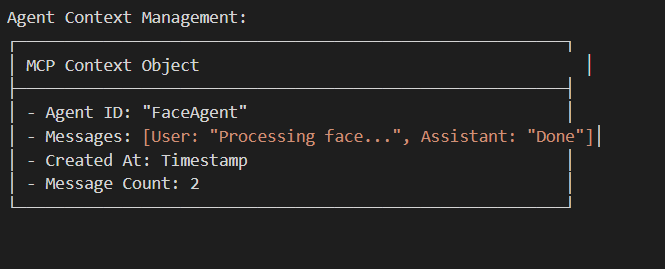

In [ ]:
class MCPAgent:
    def __init__(self, agent_id: str):
        self.agent_id = agent_id
        print(f"Agent '{self.agent_id}' initialized.")

    def process_frame(self, frame):
        raise NotImplementedError("Subclasses must implement process_frame method")

    def send_alert(self, pain_score, area, details):
        """Placeholder method for sending alerts."""
        pass

# **FACE PAIN AGENT**

In [ ]:
class FaceAgent(MCPAgent):
    def __init__(self, agent_id: str):
        super().__init__(agent_id)
        self.models = PainModels()

    def process_frame(self, frame):
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        h, w = frame.shape[:2]

        #FACE IDENTIFICATION
        face_results = self.models.face_mesh.process(rgb_frame)
        facial_pain_score = 0
        facial_features = {}

        if face_results.multi_face_landmarks:
            face_landmarks = face_results.multi_face_landmarks[0].landmark
            facial_features = self.models.extract_facial_features(face_landmarks, (h, w))
            facial_pain_score = self.models.calculate_facial_pain_score(facial_features)

        return {
            "pain_score": facial_pain_score,
            "features": facial_features
        }

# **GESTURE AGENT**

In [ ]:
class GestureAgent(MCPAgent):
    def __init__(self, agent_id: str):
        super().__init__(agent_id)
        self.models = PainModels()

    def process_frame(self, frame):
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        h, w = frame.shape[:2]

        # Process pose
        pose_results = self.models.pose.process(rgb_frame)
        pose_landmarks = pose_results.pose_landmarks
        pose_features = {}
        pose_pain_score = 0

        if pose_landmarks:
            pose_features = self.models.extract_pose_features(pose_landmarks, (h, w))
            pose_pain_score = self.models.calculate_pose_pain_score(pose_features)

        # Process hands
        hand_results = self.models.hands.process(rgb_frame)
        hand_features = {}
        hand_pain_score = 0

        if hand_results.multi_hand_landmarks:
            hand_features = self.models.extract_hand_features(hand_results.multi_hand_landmarks, (h, w))
            hand_pain_score = self.models.calculate_hand_pain_score(hand_features)

        return {
            "pose_pain_score": pose_pain_score,
            "hand_pain_score": hand_pain_score,
            "pose_features": pose_features,
            "hand_features": hand_features
        }

# **ALER SYSTEM AGENT**

In [ ]:
class AlertAgent(MCPAgent):
    def __init__(self, agent_id: str):
        super().__init__(agent_id)
        self.alert_cooldown = {}
        self.email_enabled = self._setup_email()
        self.sms_enabled = self._setup_twilio()

    def _setup_email(self):
        """Setup email client"""
        try:
            if Config.EMAIL_SENDER != 'your_email@example.com' and \
               Config.EMAIL_PASSWORD != 'your_app_password' and \
               Config.NURSE_EMAIL != 'nurse@example.com':
                return True
            return False
        except Exception:
            return False

    def _setup_twilio(self):
        """Setup Twilio client"""
        try:
            if (Config.TWILIO_ACCOUNT_SID != 'your_account_sid_here' and
                Config.TWILIO_AUTH_TOKEN != 'your_auth_token_here'):
                self.client = Client(Config.TWILIO_ACCOUNT_SID, Config.TWILIO_AUTH_TOKEN)
                return True
            return False
        except Exception:
            return False

    def send_alert(self, pain_score, area, details):
        """Send email and SMS alerts"""
        timestamp = datetime.now().strftime("%H:%M:%S")
        message_body = f"""
🚨 PAIN ALERT [{timestamp}]
Patient: {Config.PATIENT_ID}
Pain Level: {pain_score:.2f}
Area: {area}
Details: {details}
Please check immediately!
        """.strip()


        print(f"Attempting to send alert via email and SMS...")
        print(f"Email Enabled: {self.email_enabled}, SMS Enabled: {self.sms_enabled}")


        if self.email_enabled:
            try:
                msg = MIMEText(message_body)
                msg['Subject'] = 'Pain Monitoring Alert'
                msg['From'] = Config.EMAIL_SENDER
                msg['To'] = Config.NURSE_EMAIL

                server = smtplib.SMTP('smtp.gmail.com', 587)
                server.starttls()
                server.login(Config.EMAIL_SENDER, Config.EMAIL_PASSWORD)
                server.sendmail(Config.EMAIL_SENDER, Config.NURSE_EMAIL, msg.as_string())
                server.quit()
                print(f"✅ Email SENT to {Config.NURSE_EMAIL}")
            except Exception as e:
                print(f"❌ Email failed: {e}")

        #SMS DEBUG CONFIG
        if self.sms_enabled:
            try:
                message = self.client.messages.create(
                    body=message_body,
                    from_=Config.TWILIO_PHONE_NUMBER,
                    to=Config.NURSE_PHONE_NUMBER
                )
                print(f"✅ SMS SENT - SID: {message.sid}")
            except Exception as e:
                print(f"❌ SMS failed: {e}")

# **PAIN DESCRIPTION (OPTIONAL)**

In [ ]:
import openai


openai.api_key = "//your api key"

def get_pain_description(pain_score, area, details):
    """Generate a detailed description of patient pain using ChatGPT"""
    prompt = f"""
    Generate a detailed description of patient pain based on the following data:
    - Pain Score: {pain_score}
    - Affected Area: {area}
    - Details: {details}

    Provide a concise summary suitable for medical professionals.
    """

    response = openai.Completion.create(
        engine="text-davinci-003",
        prompt=prompt,
        max_tokens=100,
        n=1,
        stop=None,
        temperature=0.7,
    )

    return response.choices[0].text.strip()

# **ALERT AGENT**

In [ ]:
def send_alert(self, pain_score, area, details):
    """Send email and SMS alerts"""
    timestamp = datetime.now().strftime("%H:%M:%S")
    chatgpt_description = get_pain_description(pain_score, area, details)
    print(f"Generated ChatGPT Description: {chatgpt_description}")
    print(f"Attempting to send alert via email and SMS...")
    print(f"Email Enabled: {self.email_enabled}, SMS Enabled: {self.sms_enabled}")


    if self.email_enabled:
        try:
            msg = MIMEText(f"PAIN ALERT\n{chatgpt_description}")
            msg['Subject'] = 'Pain Monitoring Alert'
            msg['From'] = Config.EMAIL_SENDER
            msg['To'] = Config.NURSE_EMAIL

            server = smtplib.SMTP('smtp.gmail.com', 587)
            server.starttls()
            server.login(Config.EMAIL_SENDER, Config.EMAIL_PASSWORD)
            server.sendmail(Config.EMAIL_SENDER, Config.NURSE_EMAIL, msg.as_string())
            server.quit()
            print(f"✅ Email SENT to {Config.NURSE_EMAIL}")
        except Exception as e:
            print(f"❌ Email failed: {e}")


    if self.sms_enabled:
        try:
            client = Client(Config.TWILIO_ACCOUNT_SID, Config.TWILIO_AUTH_TOKEN)
            message = client.messages.create(
                body=f"PAIN ALERT\n{chatgpt_description}",
                from_=Config.TWILIO_PHONE_NUMBER,
                to=Config.NURSE_PHONE_NUMBER
            )
            print(f"✅ SMS SENT - SID: {message.sid}")
        except Exception as e:
            print(f"❌ SMS failed: {e}")

# **ALERT SYSTEM 2 BACKUP**

In [ ]:
'''class AlertSystem:
    def __init__(self):
        self.email_enabled = self._setup_email()
        self.sms_enabled = self._setup_twilio()
        self.alert_cooldown = {}

    def _setup_email(self):
        """Setup email client"""
        try:
            if Config.EMAIL_SENDER != 'your_email@example.com' and \
               Config.EMAIL_PASSWORD != 'your_app_password' and \
               Config.NURSE_EMAIL != 'nurse@example.com':
                return True
            return False
        except Exception:
            return False

    def _setup_twilio(self):
        """Setup Twilio client"""
        try:
            if (Config.TWILIO_ACCOUNT_SID != 'your_account_sid_here' and
                Config.TWILIO_AUTH_TOKEN != 'your_auth_token_here'):
                self.client = Client(Config.TWILIO_ACCOUNT_SID, Config.TWILIO_AUTH_TOKEN)
                return True
            return False
        except Exception:
            return False

    def send_alert(self, pain_score, area, details):
        """Send email and SMS alerts"""
        timestamp = datetime.now().strftime("%H:%M:%S")
        message_body = f"""
🚨 PAIN ALERT [{timestamp}]
Patient: {Config.PATIENT_ID}
Pain Level: {pain_score:.2f}
Area: {area}
Details: {details}
Please check immediately!
        """.strip()

        # Debug logs
        print(f"Attempting to send alert via email and SMS...")
        print(f"Email Enabled: {self.email_enabled}, SMS Enabled: {self.sms_enabled}")

        # Send email
        if self.email_enabled:
            try:
                msg = MIMEText(message_body)
                msg['Subject'] = 'Pain Monitoring Alert'
                msg['From'] = Config.EMAIL_SENDER
                msg['To'] = Config.NURSE_EMAIL

                server = smtplib.SMTP('smtp.gmail.com', 587)
                server.starttls()
                server.login(Config.EMAIL_SENDER, Config.EMAIL_PASSWORD)
                server.sendmail(Config.EMAIL_SENDER, Config.NURSE_EMAIL, msg.as_string())
                server.quit()
                print(f"✅ Email SENT to {Config.NURSE_EMAIL}")
            except Exception as e:
                print(f"❌ Email failed: {e}")

        # Send SMS
        if self.sms_enabled:
            try:
                message = self.client.messages.create(
                    body=message_body,
                    from_=Config.TWILIO_PHONE_NUMBER,
                    to=Config.NURSE_PHONE_NUMBER
                )
                print(f"✅ SMS SENT - SID: {message.sid}")
            except Exception as e:
                print(f"❌ SMS failed: {e}")'''

# **ALERT SYSTEM 3(BACK UP)**

In [ ]:
'''def send_alert(self, pain_score, area, details):
    """Send email and SMS alerts"""
    timestamp = datetime.now().strftime("%H:%M:%S")
    message_body = f"""
🚨 PAIN ALERT [{timestamp}]
Patient: {Config.PATIENT_ID}
Pain Level: {pain_score:.2f}
Area: {area}
Details: {details}
Please check immediately!
        """.strip()

    # Debug logs
    print(f"Attempting to send alert via email and SMS...")
    print(f"Email Enabled: {self.email_enabled}, SMS Enabled: {self.sms_enabled}")

    # Send email
    if self.email_enabled:
        try:
            msg = MIMEText(message_body)
            msg['Subject'] = 'Pain Monitoring Alert'
            msg['From'] = Config.EMAIL_SENDER
            msg['To'] = Config.NURSE_EMAIL

            server = smtplib.SMTP('smtp.gmail.com', 587)
            server.starttls()
            server.login(Config.EMAIL_SENDER, Config.EMAIL_PASSWORD)
            server.sendmail(Config.EMAIL_SENDER, Config.NURSE_EMAIL, msg.as_string())
            server.quit()
            print(f"✅ Email SENT to {Config.NURSE_EMAIL}")
        except Exception as e:
            print(f"❌ Email failed: {e}")

    # Send SMS
    if self.sms_enabled:
        try:
            message = self.client.messages.create(
                body=message_body,
                from_=Config.TWILIO_PHONE_NUMBER,
                to=Config.NURSE_PHONE_NUMBER
            )
            print(f"✅ SMS SENT - SID: {message.sid}")
        except Exception as e:
            print(f"❌ SMS failed: {e}")'''

# **MAIN AGENT (Combining all agnts MCP)**

In [ ]:
class JupyterPainMonitor:
    def __init__(self):
        self.face_agent = FaceAgent("FaceAgent")
        self.gesture_agent = GestureAgent("GestureAgent")
        self.alert_agent = AlertAgent("AlertAgent")
        self.cap = None
        self.running = False
        self.frame_count = 0
        self.last_check_time = 0
        self.models = PainModels()

    def start_monitoring(self, video_path):
        """Start monitoring with recorded video"""
        print("=" * 60)
        print("🏥 PAIN MONITORING SYSTEM FOR GOOGLE COLAB")
        print("=" * 60)
        print(f"Patient ID: {Config.PATIENT_ID}")
        print("Features: Facial expressions + Hand/Leg movements + MediaPipe")
        print("Alerts: Email via Gmail or Console")
        print("=" * 60)
        self.cap = cv2.VideoCapture(video_path)
        if not self.cap.isOpened():
            print("❌ Cannot open video file!")
            return False
        self.cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
        self.cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)
        self.cap.set(cv2.CAP_PROP_FPS, 30)
        print("✅ Video opened!")
        print("👀 Monitoring for patient discomfort...")
        print("Press 'Stop Monitoring' button to quit")
        self.running = True
        return True

    def process_frame(self, frame):
        """Process a single frame for pain detection"""
        try:
            rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            h, w = frame.shape[:2]
            face_result = self.face_agent.process_frame(frame)
            facial_pain_score = face_result["pain_score"]
            facial_features = face_result["features"]
            gesture_result = self.gesture_agent.process_frame(frame)
            pose_pain_score = gesture_result["pose_pain_score"]
            hand_pain_score = gesture_result["hand_pain_score"]
            pose_features = gesture_result["pose_features"]
            hand_features = gesture_result["hand_features"]

            emotion_pain_score = 0
            if self.frame_count % 5 == 0:
                emotion_pain_score = self.models.analyze_facial_emotions(frame)
            total_pain_score = min(facial_pain_score + pose_pain_score + hand_pain_score + emotion_pain_score, 1.0)
            area = "general"
            if hand_pain_score > facial_pain_score and hand_pain_score > pose_pain_score:
                area = "hand"
            elif pose_pain_score > facial_pain_score:
                if pose_features.get('hand_movement', 0) > pose_features.get('leg_movement', 0):
                    area = "hand"
                else:
                    area = "leg"
            elif facial_pain_score > 0.1:
                area = "face"

            return {
                "pain_score": total_pain_score,
                "area": area,
                "facial_score": facial_pain_score,
                "pose_score": pose_pain_score,
                "hand_score": hand_pain_score,
                "emotion_score": emotion_pain_score,
                "facial_features": facial_features,
                "pose_features": pose_features,
                "hand_features": hand_features
            }

        except Exception as e:
            print(f"Error processing frame: {e}")
            return {
                "pain_score": 0.0,
                "area": "general",
                "facial_score": 0.0,
                "pose_score": 0.0,
                "hand_score": 0.0,
                "emotion_score": 0.0,
                "facial_features": {},
                "pose_features": {},
                "hand_features": {}
            }

    def display_frame(self, frame, pain_result):
        """Display frame with detection overlays in Jupyter"""

        cv2.putText(frame, f"Patient: {Config.PATIENT_ID}", (10, 30),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        cv2.putText(frame, "Pain Monitoring Active", (10, 60),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        cv2.putText(frame, f"Frame: {self.frame_count}", (10, 90),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        #--------
        if pain_result and pain_result["pain_score"] > 0:
            score = pain_result["pain_score"]
            area = pain_result["area"]
            color = (0, 0, 255) if score > Config.ALERT_THRESHOLD else (0, 255, 255) if score > 0.3 else (0, 255, 0)
            cv2.putText(frame, f"Pain: {score:.2f} ({area})", (10, 120),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        clear_output(wait=True)
        plt.figure(figsize=(12, 8))
        plt.imshow(rgb_frame)
        plt.axis('off')
        plt.title('Patient Pain Monitoring - Live Feed')
        plt.tight_layout()
        plt.show()

    def stop_monitoring(self):
        """Stop monitoring and cleanup"""
        self.running = False
        if self.cap:
            self.cap.release()
        print("⏹️ Monitoring stopped")



monitor = JupyterPainMonitor()
# GUI BUTTONS
start_button = widgets.Button(
    description="▶️ Start Monitoring",
    button_style='success',
    layout=widgets.Layout(width='200px', height='50px')
)

stop_button = widgets.Button(
    description="⏹️ Stop Monitoring",
    button_style='danger',
    layout=widgets.Layout(width='200px', height='50px')
)

status_label = widgets.Label(value="Status: Ready")


def start_monitoring(button):
    start_button.disabled = True
    stop_button.disabled = False
    status_label.value = "Status: Monitoring..."

    def run_monitoring():
        video_path = "/content/WhatsApp Video 2025-08-11 at 10.55.20 AM.mp4" #path
        if monitor.start_monitoring(video_path):
            last_check_time = time.time()

            try:
                while monitor.running:
                    ret, frame = monitor.cap.read()
                    if not ret:
                        print("❌ Camera error!")
                        break

                    current_time = time.time()

                    if current_time - last_check_time >= Config.CHECK_INTERVAL:
                        pain_result = monitor.process_frame(frame)
                        pain_score = pain_result["pain_score"]
                        area = pain_result["area"]

                        if pain_score > Config.ALERT_THRESHOLD:
                            print(f"🚨 PAIN DETECTED! Score: {pain_score:.2f}, Area: {area}")
                            monitor.alert_agent.send_alert(pain_score, area, "High pain detected")

                        monitor.display_frame(frame, pain_result)
                        last_check_time = current_time

                    monitor.frame_count += 1
                    for _ in range(Config.FRAME_SKIP -1):
                         monitor.cap.read()
                    time.sleep(0.01)

            except Exception as e:
                print(f"❌ Error: {e}")
            finally:
                monitor.stop_monitoring()
                start_button.disabled = False
                stop_button.disabled = True
                status_label.value = "Status: Stopped"

    thread = threading.Thread(target=run_monitoring, daemon=True)
    thread.start()

def stop_monitoring(button):
    monitor.stop_monitoring()
    start_button.disabled = False
    stop_button.disabled = True
    status_label.value = "Status: Stopped"


start_button.on_click(start_monitoring)
stop_button.on_click(stop_monitoring)
stop_button.disabled = True
print("🎛️ Patient Pain Monitoring Control Panel")
display.display(widgets.VBox([
    widgets.HBox([start_button, stop_button]),
    status_label
]))

print("🔧 Quick System Test:")
print("✅ All packages imported successfully")

cap = cv2.VideoCapture("/content/WhatsApp Video 2025-08-11 at 10.55.20 AM.mp4")  #path
if cap.isOpened():
    ret, frame = cap.read()
    if ret:
        print("✅ Video access: SUCCESS")
    else:
        print("❌ Video access: Cannot read frame")
    cap.release()
else:
    print("❌ Video access: FAILED")

print("✅ System ready!")
print("\n📋 Instructions:")
print("1. Update Config class with your Gmail credentials")
print("2. Click 'Start Monitoring' button")
print("3. Show pain expressions/gestures in the video")
print("4. Receive alerts when pain is detected")

print("🎭 DEMO ACTIONS GUIDE")
print("=" * 40)
print("FACIAL PAIN DETECTION:")
print("• Squint eyes tightly")
print("• Furrow brows together")
print("• Open mouth wide (grimacing)")
print("• Wrinkle nose")
print("• Drop jaw")
print("• Raise cheeks")
print()
print("HAND GESTURE DETECTION:")
print("• Wave hands rapidly")
print("• Tremble/shake hands")
print("• Make fist (clench)")
print("• Pinch thumb and index finger")
print("• Move individual fingers")
print()
print("BODY MOVEMENT DETECTION:")
print("• Move arms suddenly")
print("• Kick legs")
print("• Shrug shoulders")
print()
print("ALERTS WILL BE SENT WHEN PAIN > 0.6")

Agent 'FaceAgent' initialized.
Agent 'GestureAgent' initialized.
Agent 'AlertAgent' initialized.
🎛️ Patient Pain Monitoring Control Panel


🔧 Quick System Test:
✅ All packages imported successfully
✅ Video access: SUCCESS
✅ System ready!

📋 Instructions:
1. Update Config class with your Gmail credentials
2. Click 'Start Monitoring' button
3. Show pain expressions/gestures in the video
4. Receive alerts when pain is detected
🎭 DEMO ACTIONS GUIDE
FACIAL PAIN DETECTION:
• Squint eyes tightly
• Furrow brows together
• Open mouth wide (grimacing)
• Wrinkle nose
• Drop jaw
• Raise cheeks

HAND GESTURE DETECTION:
• Wave hands rapidly
• Tremble/shake hands
• Make fist (clench)
• Pinch thumb and index finger
• Move individual fingers

BODY MOVEMENT DETECTION:
• Move arms suddenly
• Kick legs
• Shrug shoulders

ALERTS WILL BE SENT WHEN PAIN > 0.6


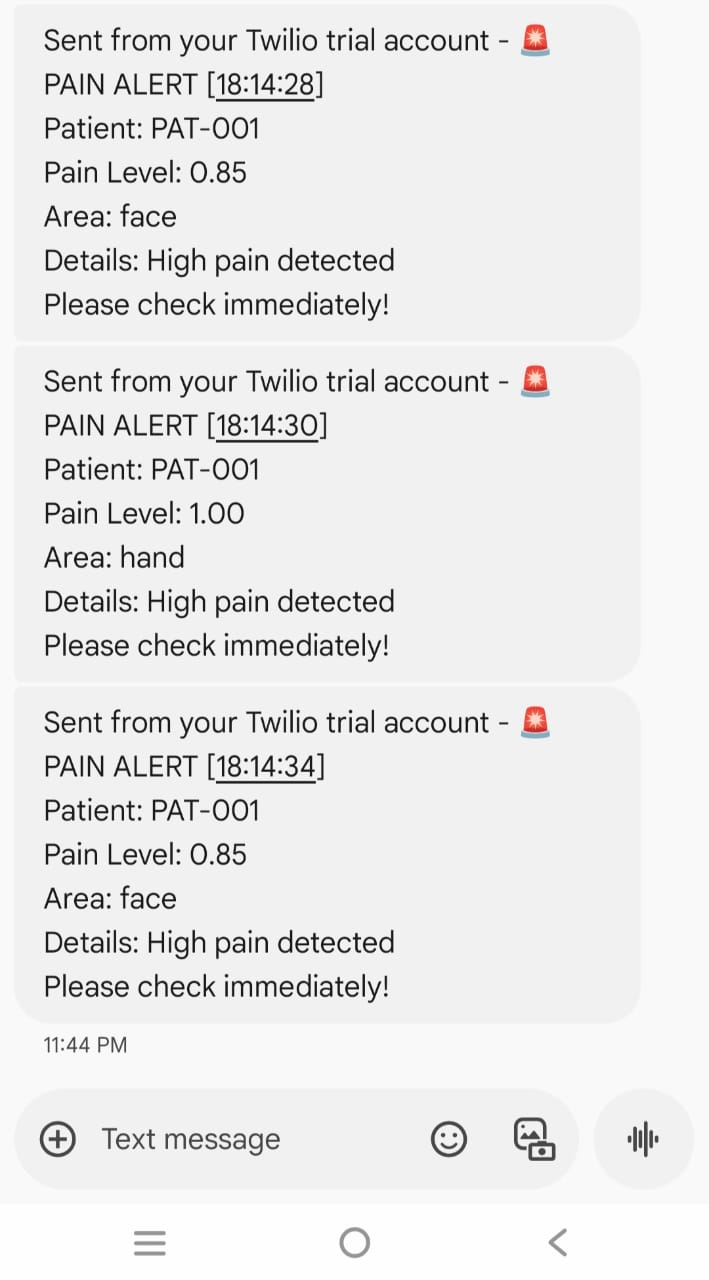

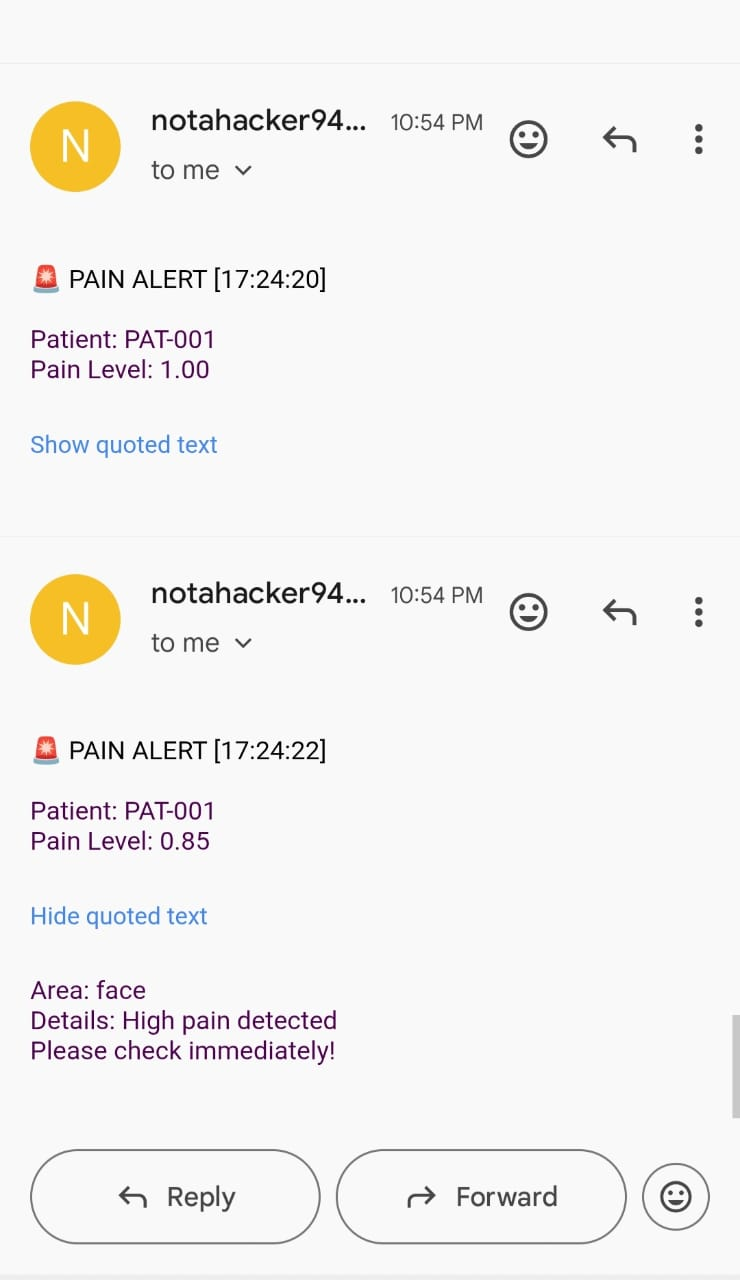